### Preprocess Text Data and Modelling 
### ANLY 590 Project


***

#### Prep

In [325]:
# set working directory
import os
import sys
path = '/Users/kgedney/Documents/georgetown/anly590/author-id-project'
os.chdir(path)

In [326]:
import numpy as np
import pandas as pd

In [327]:
# load filtered data
df = pd.read_csv('filtered_data.csv')

#### Google Colab Prep

In [0]:
import numpy as np
import pandas as pd

In [1]:
# get data from Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# manually add file from local to drive
df = pd.read_csv('filtered_data.csv')
df.head()

,author,body,subreddit,permalink,num_chars,num_words
0,GuaranteedAdmission,News aggregators don't filter Opinion pieces i...,AskAnAmerican,/r/AskAnAmerican/comments/9zrnid/america_whats...,69,11
1,GuaranteedAdmission,You can be in favor of a policy he supports an...,AskReddit,/r/AskReddit/comments/9zklcs/as_a_brit_who_onl...,74,17
2,GuaranteedAdmission,That depends. What is the penalty for breaking...,AskReddit,/r/AskReddit/comments/9zkfcd/how_would_you_fee...,202,36
3,GuaranteedAdmission,Because I like to think long term. Tax cuts fo...,AskReddit,/r/AskReddit/comments/9yxl98/liberals_of_reddi...,120,22
4,GuaranteedAdmission,"We don't talk about the Highway Shoes, OP! Are...",AskReddit,/r/AskReddit/comments/9yrbvd/people_who_lost_a...,110,22


In [5]:
# download nltk
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

#### Text Cleaning

ref: https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

In [328]:
# remove URLs and replace as '<url>'
import re
df['body_no_urls'] = df.apply(lambda row: re.sub(r"http\S+", "<url>", row['body']), axis=1) 

In [329]:
# tokenize
from nltk.tokenize import word_tokenize
df['tokenized_nltk']  = df.apply(lambda row: word_tokenize(row['body_no_urls']), axis=1)

In [0]:
# remove NERs

In [0]:
# import spacy
# nlp = spacy.load('en')

In [0]:
# def get_ners(input_doc):
#     doc = nlp(input_doc)
#     ners = str(doc.ents)
#     return (ners)

***

#### Preprocess  for Modelling

In [330]:
# install packages
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import keras
from keras import optimizers
import tensorflow as tf

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.models import Model, Sequential
from keras.layers import Input, Dense, CuDNNLSTM, LSTM, Embedding, Bidirectional, GlobalAveragePooling1D, Conv1D, Activation, Flatten, Dropout, MaxPooling1D, Embedding, GlobalMaxPooling1D

from keras.layers.core import Dense, Dropout

In [331]:
# create class assignments
df['author_id'] = pd.Categorical(df.author).codes

#### 0. Baseline Model: Linear SVM

In [10]:
x = df['body_no_urls'].values
y = df['author_id'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=22)

tfidf_vec   = TfidfVectorizer()
x_train_vec = tfidf_vec.fit_transform(x_train)
x_test_vec  = tfidf_vec.transform(x_test)
x_train_vec.shape

(58129, 53161)

In [0]:
from sklearn.svm import LinearSVC
clf             = LinearSVC().fit(x_train_vec, y_train)
predicted       = clf.predict(x_test_vec)
predicted_score = clf.decision_function(x_test_vec)

In [12]:
print('accuracy', metrics.accuracy_score(y_test, predicted))

accuracy 0.37789857565540497


In [0]:
# top k accuracy (# ref: https://scikit-learn.org/stable/modules/svm.html)
predicted_score = clf.decision_function(x_test_vec)
predicted_score.shape

In [0]:
# transform matrix of predictions to put them in order
best_n = predicted_score.argsort()[:,::-1] # need to do in reverse order thats why need "[::-1]"

In [0]:
# set up function to calculate
count = 0
for i in range(0, y_test.shape[0]):
    if (y_test[i] in best_n[i,0:5]):
        count = count + 1

top_5_acc = count / y_test.shape[0]
top_5_acc

#### Preprocess Data for Keras Models

In [332]:
# data preprocess
x = df['tokenized_nltk'].values
y = df['author_id'].values

# create sequences
max_features = 25000
tokenizer    = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(x)
x_sequences  = tokenizer.texts_to_sequences(x)

# pad each sequence to be max length
maxlen = max(len(x) for x in x_sequences)
print(maxlen)
x_sequences = sequence.pad_sequences(x_sequences, maxlen)

236


In [0]:
# from keras.utils import to_categorical
# print(y.shape)
# y = to_categorical(y)
# print(y.shape)

(72662,)
(72662, 100)


In [333]:
# split test and train
x_train, x_test, y_train, y_test = train_test_split(x_sequences, y, test_size=0.20, random_state=22)

#### 1. Faster RNN Model: CuDNNLSTM 

- Run on Google Colab, 14 mins.    
- Very overfit

In [0]:
# ref: https://keras.io/layers/recurrent/#cudnnlstm
# faster LSTM implementation

model1 = Sequential()
model1.add(Embedding(input_dim=max_features,
                     output_dim=128))
model1.add(CuDNNLSTM(128))
model1.add(Dropout(0.5))
model1.add(Dense(100, activation="softmax"))

model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [29]:
history1 = model1.fit(x_train, y_train,
            batch_size=128,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 28s 488us/step - loss: 4.3931 - acc: 0.0378 - val_loss: 4.1605 - val_acc: 0.0605
Epoch 2/16
58129/58129 [==============================] - 28s 478us/step - loss: 4.0029 - acc: 0.0878 - val_loss: 3.8811 - val_acc: 0.1096
Epoch 3/16
58129/58129 [==============================] - 28s 476us/step - loss: 3.6247 - acc: 0.1495 - val_loss: 3.7126 - val_acc: 0.1479
Epoch 4/16
58129/58129 [==============================] - 28s 479us/step - loss: 3.2245 - acc: 0.2255 - val_loss: 3.5383 - val_acc: 0.1886
Epoch 5/16
58129/58129 [==============================] - 28s 477us/step - loss: 2.8306 - acc: 0.3098 - val_loss: 3.5387 - val_acc: 0.2068
Epoch 6/16
58129/58129 [==============================] - 28s 475us/step - loss: 2.4861 - acc: 0.3881 - val_loss: 3.5731 - val_acc: 0.2205
Epoch 7/16
58129/58129 [==============================] - 28s 477us/step - loss: 2.1764 - acc: 0.4613 - val_loss: 3.

In [17]:
print('accuracy', model1.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 6s 421us/step
accuracy 0.24482212894893698


In [18]:
print('accuracy', model1.evaluate(x_train, y_train)[1])

58129/58129 [==============================] - 25s 422us/step
accuracy 0.9159455693402401


#### 2. CNN

In [0]:
model_conv2 = Sequential()
model_conv2.add(Embedding(max_features, output_dim = 30, input_length=236))
model_conv2.add(Dropout(0.2))
model_conv2.add(Conv1D(128, 5, activation='relu'))
model_conv2.add(Conv1D(128, 5, activation='relu'))
model_conv2.add(GlobalMaxPooling1D())
model_conv2.add(Dropout(0.2))
model_conv2.add(Dense(100, activation='softmax'))

In [0]:
from keras import optimizers
opt = optimizers.rmsprop(lr=0.001) # speed up optimization
model_conv2.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])


In [35]:
history2 = model_conv2.fit(x_train, y_train,
            batch_size=128,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 11s 188us/step - loss: 4.4664 - acc: 0.0254 - val_loss: 4.2822 - val_acc: 0.0520
Epoch 2/16
58129/58129 [==============================] - 10s 178us/step - loss: 4.2079 - acc: 0.0592 - val_loss: 4.1073 - val_acc: 0.0750
Epoch 3/16
58129/58129 [==============================] - 10s 178us/step - loss: 4.0162 - acc: 0.0892 - val_loss: 3.9565 - val_acc: 0.1044
Epoch 4/16
58129/58129 [==============================] - 10s 178us/step - loss: 3.8364 - acc: 0.1194 - val_loss: 3.8121 - val_acc: 0.1280
Epoch 5/16
58129/58129 [==============================] - 10s 178us/step - loss: 3.6756 - acc: 0.1485 - val_loss: 3.7152 - val_acc: 0.1531
Epoch 6/16
58129/58129 [==============================] - 10s 178us/step - loss: 3.5385 - acc: 0.1714 - val_loss: 3.6596 - val_acc: 0.1660
Epoch 7/16
58129/58129 [==============================] - 10s 178us/step - loss: 3.4033 - acc: 0.1968 - val_loss: 3.

In [36]:
model_conv2.evaluate(x_test,y_test)


14533/14533 [==============================] - 2s 116us/step


[3.428831457017187, 0.23505126264466394]

#### 3. CNN + LSTM

In [0]:
model_conv3 = Sequential()
model_conv3.add(Embedding(max_features, output_dim = 30, input_length=236))
model_conv3.add(Dropout(0.2))
model_conv3.add(Conv1D(128, 5, activation='relu'))
model_conv3.add(MaxPooling1D(4))
model_conv3.add(LSTM(100))
#model_conv.add(GlobalMaxPooling1D())

model_conv3.add(Dense(100, activation='softmax'))

In [0]:
opt = optimizers.rmsprop(lr=0.001) # speed up optimization
model_conv3.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [43]:
history3 = model_conv3.fit(x_train, y_train,
            batch_size=128,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 80s 1ms/step - loss: 4.4109 - acc: 0.0328 - val_loss: 4.2530 - val_acc: 0.0526
Epoch 2/16
58129/58129 [==============================] - 79s 1ms/step - loss: 4.0749 - acc: 0.0781 - val_loss: 3.9975 - val_acc: 0.0848
Epoch 3/16
58129/58129 [==============================] - 80s 1ms/step - loss: 3.7999 - acc: 0.1205 - val_loss: 3.8215 - val_acc: 0.1206
Epoch 4/16
58129/58129 [==============================] - 79s 1ms/step - loss: 3.6037 - acc: 0.1515 - val_loss: 3.7453 - val_acc: 0.1307
Epoch 5/16
58129/58129 [==============================] - 79s 1ms/step - loss: 3.4513 - acc: 0.1787 - val_loss: 3.6918 - val_acc: 0.1451
Epoch 6/16
58129/58129 [==============================] - 78s 1ms/step - loss: 3.3130 - acc: 0.2066 - val_loss: 3.6160 - val_acc: 0.1618
Epoch 7/16
58129/58129 [==============================] - 80s 1ms/step - loss: 3.1778 - acc: 0.2340 - val_loss: 3.5468 - val_acc

In [44]:
model_conv3.evaluate(x_test, y_test)


14533/14533 [==============================] - 27s 2ms/step


[3.503996890483503, 0.2366338677492603]

#### 4. Simple Pooling Model

In [0]:
#ref: https://github.com/keras-team/keras/blob/master/examples/imdb_fasttext.py

In [334]:
model4 = Sequential()
model4.add(Embedding(input_dim=max_features,
                    output_dim=128))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model4.add(GlobalAveragePooling1D())
model4.add(Dropout(0.5))

model4.add(Dense(100, activation="softmax"))

In [335]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model4.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [336]:
history4 = model4.fit(x_train, y_train,
            batch_size=256,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 14s 242us/step - loss: 4.4572 - acc: 0.0418 - val_loss: 4.2301 - val_acc: 0.0888
Epoch 2/16
58129/58129 [==============================] - 14s 246us/step - loss: 3.9854 - acc: 0.1364 - val_loss: 3.7647 - val_acc: 0.1914
Epoch 3/16
58129/58129 [==============================] - 15s 258us/step - loss: 3.5156 - acc: 0.2304 - val_loss: 3.4225 - val_acc: 0.2556
Epoch 4/16
58129/58129 [==============================] - 14s 242us/step - loss: 3.1244 - acc: 0.3100 - val_loss: 3.1842 - val_acc: 0.3005
Epoch 5/16
58129/58129 [==============================] - 14s 243us/step - loss: 2.7931 - acc: 0.3828 - val_loss: 2.9930 - val_acc: 0.3384
Epoch 6/16
58129/58129 [==============================] - 14s 244us/step - loss: 2.5122 - acc: 0.4424 - val_loss: 2.8550 - val_acc: 0.3630
Epoch 7/16
58129/58129 [==============================] - 15s 251us/step - loss: 2.2685 - acc: 0.4973 - val_loss: 2.

In [338]:
print('accuracy', model4.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 1s 45us/step
accuracy 0.418839881649687


#### Plots + Compare Models

In [396]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")


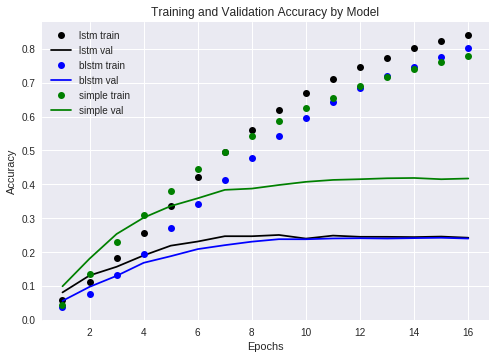

In [0]:
# plot test vs. train to show overfitting!

# Get values 
acc1     = history1.history['acc']
val_acc1 = history1.history['val_acc']

acc2     = history2.history['acc']
val_acc2 = history2.history['val_acc']

acc3     = history3.history['acc']
val_acc3 = history3.history['val_acc']


# Setup grid for plotting
epochs = range(1, len(acc) + 1)

# plot model 1
plt.plot(epochs, acc1, 'bo', label='lstm train', color='k')
plt.plot(epochs, val_acc1, 'b', label='lstm val', color='k')

# plot model 2
plt.plot(epochs, acc2, 'bo', label='blstm train', color='b')
plt.plot(epochs, val_acc2, 'b', label='blstm val', color='b')

# plot model 3
plt.plot(epochs, acc3, 'bo', label='simple train', color='g')
plt.plot(epochs, val_acc3, 'b', label='simple val', color='g')

plt.title('Training and Validation Accuracy by Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [339]:
# plot accuracy rates by author from best model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

y_pred4 = model4.predict_classes(x_test)
# print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred4) #only works with sparse
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracies = cm.diagonal()

In [340]:
test_scores = model4.predict(x_test) # basically the softmax output

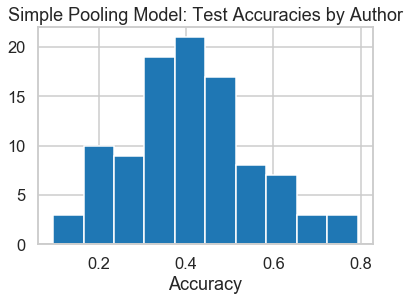

In [397]:
plt.hist(accuracies, bins=10)
plt.title('Simple Pooling Model: Test Accuracies by Author')
plt.xlabel('Accuracy')
plt.show()

##### Top K Analysis

In [0]:
# get predictions for each DL model
y_pred1 = model1.predict_classes(x_test)
y_pred2 = model_conv2.predict_classes(x_test)
y_pred3 = model_conv3.predict_classes(x_test)
y_pred4 = model4.predict_classes(x_test)

# get scores
test_scores1 = model1.predict(x_test) # basically the softmax output
test_scores2 = model_conv2.predict(x_test) # basically the softmax output
test_scores3 = model_conv3.predict(x_test) # basically the softmax output
test_scores4 = model4.predict(x_test) # basically the softmax output

In [0]:
def topk_acc(y_test, y_pred, k):
  return keras.backend.eval(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_pred, k=k)) # force it to evaluate

topk1 = [(k, topk_acc(y_test, test_scores1, k=k)) for k in range(1, 10)]
topk2 = [(k, topk_acc(y_test, test_scores2, k=k)) for k in range(1, 10)]
topk3 = [(k, topk_acc(y_test, test_scores3, k=k)) for k in range(1, 10)]
topk4 = [(k, topk_acc(y_test, test_scores4, k=k)) for k in range(1, 10)]

In [0]:
# lots of politics, and very consistent writing style
print(accuracies.max())
print(accuracies.argmax())
print(df[['author', 'body']][df['author_id'] == 68][0:5])

0.7517241379310344
68
      author                                               body
9346  djphan  Kansas is an underrated pickup opportunity... ...
9347  djphan  how can i point to their argument without usin...
9348  djphan  i did.. i see the subsequent comments... and t...
9349  djphan  i literally quoted it in my first reply...  \n...
9350  djphan  youre saying that clinton did it herself... th...


##### Author and Post Length Analysis

In [348]:
y_pred4 = model4.predict_classes(x_test)

In [372]:
x_test_length = (x_test != 0).sum(axis=1) 

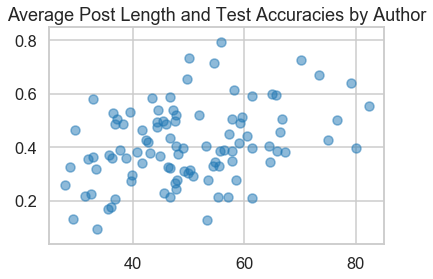

In [398]:
length_by_author = pd.Series(x_test_length).groupby(y_test).mean() #avg post length, in tokens
acc_by_author    = pd.Series(y_pred4 == y_test).groupby(y_test).mean()

plt.scatter(length_by_author, acc_by_author, alpha=0.5)
plt.title('Average Post Length and Test Accuracies by Author')
plt.show()

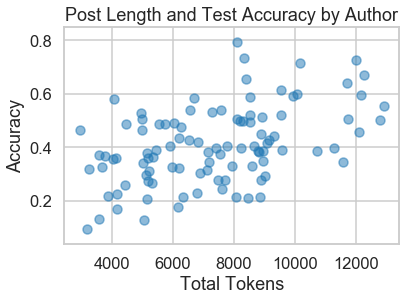

In [399]:
length_by_author = pd.Series(x_test_length).groupby(y_test).sum() # take sum
acc_by_author    = pd.Series(y_pred4 == y_test).groupby(y_test).mean()

plt.scatter(length_by_author, acc_by_author, alpha=0.5)
plt.title('Post Length and Test Accuracy by Author')
plt.ylabel('Accuracy')
plt.xlabel('Total Tokens')
plt.show()

#### Save Models

In [0]:
model1.save('/content/gdrive/My Drive/colab/anly-author-id/model_l.h5')
model2.save('/content/gdrive/My Drive/colab/anly-author-id/model_2.h5')
model3.save('/content/gdrive/My Drive/colab/anly-author-id/model_3.h5')

#### EXTRA. Multilayer

In [0]:
# Multilayer LSTM
model5 = Sequential()
model5.add(Embedding(input_dim=max_features,
                    output_dim=128))

model5.add(CuDNNLSTM(128, return_sequences=True))
model5.add(Dropout(0.5))

model5.add(CuDNNLSTM(64))
model5.add(Dropout(0.5))

model5.add(Dense(100, activation="softmax"))

model5.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
history5 = model5.fit(x_train, y_train,
            batch_size=256,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 46s 797us/step - loss: 4.4563 - acc: 0.0301 - val_loss: 4.2198 - val_acc: 0.0588
Epoch 2/16
58129/58129 [==============================] - 44s 764us/step - loss: 4.1062 - acc: 0.0710 - val_loss: 3.9898 - val_acc: 0.0962
Epoch 3/16
58129/58129 [==============================] - 44s 756us/step - loss: 3.8289 - acc: 0.1135 - val_loss: 3.7824 - val_acc: 0.1303
Epoch 4/16
58129/58129 [==============================] - 44s 765us/step - loss: 3.6063 - acc: 0.1513 - val_loss: 3.6834 - val_acc: 0.1494
Epoch 5/16
58129/58129 [==============================] - 44s 761us/step - loss: 3.4146 - acc: 0.1893 - val_loss: 3.6164 - val_acc: 0.1682
Epoch 6/16
58129/58129 [==============================] - 44s 753us/step - loss: 3.2467 - acc: 0.2262 - val_loss: 3.5665 - val_acc: 0.1844
Epoch 7/16
58129/58129 [==============================] - 44s 754us/step - loss: 3.0894 - acc: 0.2571 - val_loss: 3.

In [0]:
print('accuracy', model4.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 13s 883us/step
accuracy 0.22183995045860463


#### EXTRA. Bidirectional

- Also overfits 

In [0]:
# Bidirectional
model2 = Sequential()
model2.add(Embedding(input_dim=max_features,
                     output_dim=128))

model2.add(Bidirectional(CuDNNLSTM(128)))
model2.add(Dropout(0.5))
model2.add(Dense(100, activation="softmax"))

model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
history2 = model2.fit(x_train, y_train,
            batch_size=128,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 51s 885us/step - loss: 4.3861 - acc: 0.0376 - val_loss: 4.1800 - val_acc: 0.0564
Epoch 2/16
58129/58129 [==============================] - 51s 870us/step - loss: 4.0185 - acc: 0.0777 - val_loss: 3.9345 - val_acc: 0.0977
Epoch 3/16
58129/58129 [==============================] - 51s 872us/step - loss: 3.6703 - acc: 0.1319 - val_loss: 3.7773 - val_acc: 0.1301
Epoch 4/16
58129/58129 [==============================] - 51s 871us/step - loss: 3.3328 - acc: 0.1960 - val_loss: 3.6396 - val_acc: 0.1686
Epoch 5/16
58129/58129 [==============================] - 50s 866us/step - loss: 2.9899 - acc: 0.2714 - val_loss: 3.5972 - val_acc: 0.1881
Epoch 6/16
58129/58129 [==============================] - 51s 870us/step - loss: 2.6527 - acc: 0.3420 - val_loss: 3.6188 - val_acc: 0.2090
Epoch 7/16
58129/58129 [==============================] - 50s 868us/step - loss: 2.3577 - acc: 0.4141 - val_loss: 3.

In [0]:
print('accuracy', model2.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 11s 758us/step
accuracy 0.2401431225486823


#### EXTRA. GRU

In [0]:
# Bidirectional
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_features,
                     output_dim=128))

model_gru.add(Bidirectional(CuDNNLSTM(128)))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(100, activation="softmax"))

model_gru.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])